In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

c:\Users\elote\miniconda3\envs\datasciml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of dataset
path = kagglehub.dataset_download("yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\elote\.cache\kagglehub\datasets\yanmaksi\big-startup-secsees-fail-dataset-from-crunchbase\versions\1


In [3]:
# List files in the dataset
files = os.listdir(path)
print("Files in the dataset:", files)

Files in the dataset: ['big_startup_secsees_dataset.csv']


In [4]:
# read csv into pandas dataframe
# reads first file in the dataset (verify if it is the correct file)
first_file = files[0]
print("Using file:", first_file)

# Read the file based on its extension
file_path = os.path.join(path, first_file)
if first_file.endswith('.csv'):
    df = pd.read_csv(file_path)

Using file: big_startup_secsees_dataset.csv


In [5]:
# drop rows with missing values
df = df.dropna()

In [6]:
def filter_invalid_dates(df, date_columns):
    """
    Remove rows where any specified date column falls outside pandas datetime range
    (1677-09-22 to 2262-04-11) or contains invalid date format
    """
    min_date = datetime(1677, 9, 22)
    max_date = datetime(2262, 4, 11)
    
    # Create a boolean mask for valid dates
    valid_mask = pd.Series(True, index=df.index)
    
    for col in date_columns:
        col_mask = df[col].apply(lambda x: True if pd.isna(x) else False)  # Keep NaN values
        
        def check_date(x):
            if pd.isna(x):
                return True
            try:
                date = datetime.strptime(x, '%Y-%m-%d')
                return min_date <= date <= max_date
            except ValueError:
                return False
        
        valid_dates = df[col].apply(check_date)
        valid_mask &= valid_dates
    
    # Return filtered dataframe and number of dropped rows
    filtered_df = df[valid_mask]
    dropped_count = len(df) - len(filtered_df)
    
    return filtered_df, dropped_count

# remove rows with invalid dates
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
df, n_dropped = filter_invalid_dates(df, date_cols)

# print(f"Rows dropped: {n_dropped}")

In [7]:
# change data type of founded_at, first_funding_at, last_funding_at to datetime
df['founded_at'] = pd.to_datetime(df['founded_at'])
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])

# change data type of funding_total_usd to float
# Replace '-' with NaN first
df['funding_total_usd'] = df['funding_total_usd'].replace('-', float('nan'))
df['funding_total_usd'] = df['funding_total_usd'].astype(float)

In [8]:
# cols = df.columns
# print(cols)

In [9]:
# Define a function to remove outliers using the IQR method
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Remove outliers from the 'funding_total_usd' column
df = remove_outliers(df, 'funding_total_usd')


In [10]:
# Basic analysis of dates
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
print("Date range for each column:")
for col in date_cols:
    print(f"\n{col}:")
    print(f"Range: {df[col].min()} to {df[col].max()}")
    print(f"Null values: {df[col].isnull().sum()}")
    print(f"Unique values: {df[col].nunique()}")

# Create useful derived features
df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
df['funding_duration'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['company_age_at_last_funding'] = (df['last_funding_at'] - df['founded_at']).dt.days

# Extract year and month features
for col in date_cols:
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    
# Time-based features
df['founded_quarter'] = df['founded_at'].dt.quarter
df['is_founded_recession_2008'] = ((df['founded_at'].dt.year >= 2008) & 
                                 (df['founded_at'].dt.year <= 2009)).astype(int)
df['is_founded_covid'] = (df['founded_at'].dt.year >= 2020).astype(int)

# Summary statistics of the new features
print("\nSummary of derived time features:")
time_features = ['days_to_first_funding', 'funding_duration', 'company_age_at_last_funding']
print(df[time_features].describe())

# Check for any illogical values
print("\nChecking for illogical values:")
print("Negative days to first funding:", 
      (df['days_to_first_funding'] < 0).sum())
print("Negative funding duration:", 
      (df['funding_duration'] < 0).sum())

Date range for each column:

founded_at:
Range: 1766-01-01 00:00:00 to 2104-01-01 00:00:00
Null values: 0
Unique values: 3111

first_funding_at:
Range: 1977-05-15 00:00:00 to 2015-12-05 00:00:00
Null values: 0
Unique values: 3783

last_funding_at:
Range: 1977-05-15 00:00:00 to 2105-05-01 00:00:00
Null values: 0
Unique values: 3464

Summary of derived time features:
       days_to_first_funding  funding_duration  company_age_at_last_funding
count           31403.000000      31403.000000                 31403.000000
mean             1272.494539        353.469159                  1625.963698
std              3286.982811        627.370299                  3312.289102
min            -33055.000000          0.000000                -33055.000000
25%               151.500000          0.000000                   375.000000
50%               516.000000          0.000000                   886.000000
75%              1294.000000        538.000000                  1827.000000
max             91028.00

In [11]:
# Store original length
original_len = len(df)

# Get today's date
today = pd.Timestamp.today()

df = df[
   # No future dates in last_funding_at
   (df['last_funding_at'] <= today) &
   # First funding should be after founding
   (df['days_to_first_funding'] >= 0) &
   # Last funding should be after first funding
   (df['funding_duration'] >= 0) &
   # All dates should exist (not null)
   df[date_cols].notna().all(axis=1)
]

# Show how many rows were dropped
rows_dropped = original_len - len(df)
print(f"Dropped {rows_dropped} rows ({(rows_dropped/original_len)*100:.2f}% of data)")
print(f"Remaining rows: {len(df)}")

# Verify no more illogical values exist
print("\nVerifying no illogical values remain:")
print("Negative days to first funding:", (df['days_to_first_funding'] < 0).sum())
print("Negative funding duration:", (df['funding_duration'] < 0).sum())
print("Null dates:", df[date_cols].isnull().sum())

Dropped 2222 rows (7.08% of data)
Remaining rows: 29181

Verifying no illogical values remain:
Negative days to first funding: 0
Negative funding duration: 0
Null dates: founded_at          0
first_funding_at    0
last_funding_at     0
dtype: int64


In [12]:
# # Look at some statistics
# print("Sample of unique category combinations:")
# print(df['category_list'].value_counts().head())

# print("\nTotal unique category combinations:")
# print(df['category_list'].nunique())

# # Get list of all unique individual categories
# all_categories = set()
# df['category_list'].str.split('|').dropna().apply(all_categories.update)
# print("\nTotal unique individual categories:", len(all_categories))
# print("\nSample of individual categories:")
# print(list(all_categories)[:10])

In [13]:
# top categories
top_tier = ['Software', 'Mobile', 'E-Commerce', 'Social Media', 'Curated Web', 
            'Biotechnology', 'Enterprise Software', 'Advertising', 'SaaS']

# Define all our keyword groups (same as before)
tech_keywords = ['Software', 'Enterprise Software', 'SaaS', 'Cloud Computing', 
                'Hardware + Software', 'Information Technology', 'Technology']

health_keywords = ['Biotechnology', 'Health and Wellness', 'Health Care', 
                  'Medical', 'Medical Devices', 'Pharmaceuticals', 'Life Sciences']

mobile_keywords = ['Mobile', 'Apps', 'Android', 'iOS', 'iPhone', 'iPad', 
                  'Mobile Commerce', 'Mobile Payments']

social_keywords = ['Social Media', 'Social Network Media', 'Social Commerce',
                  'Social Games', 'Social Media Marketing']

data_keywords = ['Analytics', 'Big Data', 'Big Data Analytics', 
                'Predictive Analytics', 'Data Mining', 'Data Visualization']

finance_keywords = ['Finance', 'FinTech', 'Financial Services', 'Payments',
                   'Banking', 'Insurance', 'Investment Management']

def create_category_features(df):
    """
    Create category-based features from the category_list column
    Returns categories in column format instead of binary flags
    """
    # Create a copy to avoid modifying the original
    df_new = df.copy()
    
    # Initialize new columns
    df_new['sectors'] = ''
    df_new['top_categories'] = ''
    
    # Create sector mapping
    sector_keywords = {
        'Tech': tech_keywords,
        'Health': health_keywords,
        'Mobile': mobile_keywords,
        'Social': social_keywords,
        'Data': data_keywords,
        'Finance': finance_keywords
    }
    
    # Add sectors
    for idx, row in df_new.iterrows():
        sectors = []
        if pd.notna(row['category_list']):
            # Check each sector
            for sector, keywords in sector_keywords.items():
                if any(keyword in row['category_list'] for keyword in keywords):
                    sectors.append(sector)
        df_new.at[idx, 'sectors'] = '|'.join(sectors) if sectors else 'None'
        
        # Check top categories
        top_cats = []
        if pd.notna(row['category_list']):
            for category in top_tier:
                if category in row['category_list']:
                    top_cats.append(category)
        df_new.at[idx, 'top_categories'] = '|'.join(top_cats) if top_cats else 'None'
    
    # Add category count (using raw string for escape sequence)
    df_new['category_count'] = df_new['category_list'].str.count(r'\|') + 1
    df_new['sector_count'] = df_new['sectors'].str.count(r'\|') + 1
    
    return df_new

# Example usage:
df = create_category_features(df)

# Display results
print("\nSample of categorized data:")
print(df[['category_list', 'sectors', 'top_categories', 'category_count', 'sector_count']].head())

# Show distribution of sectors
print("\nSector combinations distribution:")
print(df['sectors'].value_counts().head(10))

print("\nTop categories combinations distribution:")
print(df['top_categories'].value_counts().head(10))


Sample of categorized data:
                                category_list sectors top_categories  \
3                                 Curated Web    None    Curated Web   
6                               Biotechnology  Health  Biotechnology   
9                                  E-Commerce    None     E-Commerce   
13                        Health and Wellness  Health           None   
14  Internet Marketing|Media|Public Relations    None           None   

    category_count  sector_count  
3                1             1  
6                1             1  
9                1             1  
13               1             1  
14               3             1  

Sector combinations distribution:
sectors
None             10503
Tech              6723
Health            3227
Mobile            2168
Social            1221
Tech|Mobile        842
Finance            838
Data               639
Tech|Data          495
Mobile|Social      418
Name: count, dtype: int64

Top categories combinations 

In [14]:
# List of columns we want to keep
columns_to_keep = ['funding_total_usd', 'status', 'country_code', #'region',
                 'funding_rounds', 'founded_at', 'last_funding_at', 
                 'days_to_first_funding', 'funding_duration',
                 'company_age_at_last_funding', 'founded_at_year', 
                 'founded_at_month', 'first_funding_at_year', 
                 'first_funding_at_month', 'last_funding_at_year', 
                 'last_funding_at_month', 'founded_quarter',
                 'is_founded_recession_2008', 'is_founded_covid', 'sectors',
                  'top_categories', 'category_count', 'sector_count']

# Filter for selected countries and columns
df = df[
   # Country filter
   (df['country_code'].isin(['USA', 'GBR', 'CAN']))
   # Select columns
][columns_to_keep]

# Show results
print("New shape:", df.shape)
print("\nData distribution by country:")
print(df['country_code'].value_counts())

New shape: (21826, 22)

Data distribution by country:
country_code
USA    18940
GBR     1875
CAN     1011
Name: count, dtype: int64


In [15]:
def one_hot_encode_columns(df):
   # Function to one-hot encode pipe-separated columns
   def one_hot_encode_piped_columns(df, column_name):
       temp_df = df[column_name].str.get_dummies(sep='|')
       if 'None' in temp_df.columns:
           temp_df = temp_df.drop('None', axis=1)
       temp_df = temp_df.add_prefix(f'{column_name}_')
       return temp_df
   
   # Create one-hot encoded features for pipe-separated columns
   sectors_encoded = one_hot_encode_piped_columns(df, 'sectors')
   top_cats_encoded = one_hot_encode_piped_columns(df, 'top_categories')
   
   # One-hot encode regular categorical columns
   #region_encoded = pd.get_dummies(df['region'], prefix='region')
   country_encoded = pd.get_dummies(df['country_code'], prefix='country')
   
   # Combine all features
   df_encoded = pd.concat([
       df,
       sectors_encoded,
       top_cats_encoded,
       #region_encoded,
       country_encoded
   ], axis=1)
   
   # Drop original categorical columns
   #columns_to_drop = ['sectors', 'top_categories', 'region', 'country_code']
   columns_to_drop = ['sectors', 'top_categories', 'country_code']
   df_encoded = df_encoded.drop(columns_to_drop, axis=1)
   
   return df_encoded

# Apply encoding
df_final = one_hot_encode_columns(df)

# Show results
print("Original shape:", df.shape)
print("New shape:", df_final.shape)
print("\nNew column groups:")
print("\nSector columns:", [col for col in df_final.columns if col.startswith('sectors_')])
print("\nTop category columns:", [col for col in df_final.columns if col.startswith('top_categories_')])
print("\nRegion columns:", [col for col in df_final.columns if col.startswith('region_')])
print("\nCountry columns:", [col for col in df_final.columns if col.startswith('country_')])

# Show sample of encoded data
print("\nSample of encoded data (first few columns):")
encoded_cols = [col for col in df_final.columns if col.startswith(('sectors_', 'region_', 'country_'))]
print(df_final[encoded_cols[:5]].head())

Original shape: (21826, 22)
New shape: (21826, 37)

New column groups:

Sector columns: ['sectors_Data', 'sectors_Finance', 'sectors_Health', 'sectors_Mobile', 'sectors_Social', 'sectors_Tech']

Top category columns: ['top_categories_Advertising', 'top_categories_Biotechnology', 'top_categories_Curated Web', 'top_categories_E-Commerce', 'top_categories_Enterprise Software', 'top_categories_Mobile', 'top_categories_SaaS', 'top_categories_Social Media', 'top_categories_Software']

Region columns: []

Country columns: ['country_CAN', 'country_GBR', 'country_USA']

Sample of encoded data (first few columns):
    sectors_Data  sectors_Finance  sectors_Health  sectors_Mobile  \
6              0                0               1               0   
13             0                0               1               0   
14             0                0               0               0   
15             0                0               0               1   
17             0                0          

In [16]:
# import libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

Status categories: {'acquired': 0, 'closed': 1, 'ipo': 2, 'operating': 3}

Performing cross-validation...

Logistic Regression Cross-Validation Scores: [0.82321497 0.81901489 0.82436044 0.81634212 0.82245132]
Logistic Regression Average CV Score: 0.821 (+/- 0.006)

Random Forest Cross-Validation Scores: [0.81939672 0.82474227 0.82321497 0.82206949 0.82436044]
Random Forest Average CV Score: 0.823 (+/- 0.004)

XGBoost Cross-Validation Scores: [0.82703322 0.82550592 0.82512409 0.82168767 0.82245132]
XGBoost Average CV Score: 0.824 (+/- 0.004)

Training and evaluating models...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    acquired       0.45      0.17      0.25       416
      closed       0.38      0.02      0.03       300
         ipo       0.25      0.01      0.02        82
   operating       0.83      0.98      0.90      3567

    accuracy                           0.82      4365
   macro avg       0.48      0.30      0.30     

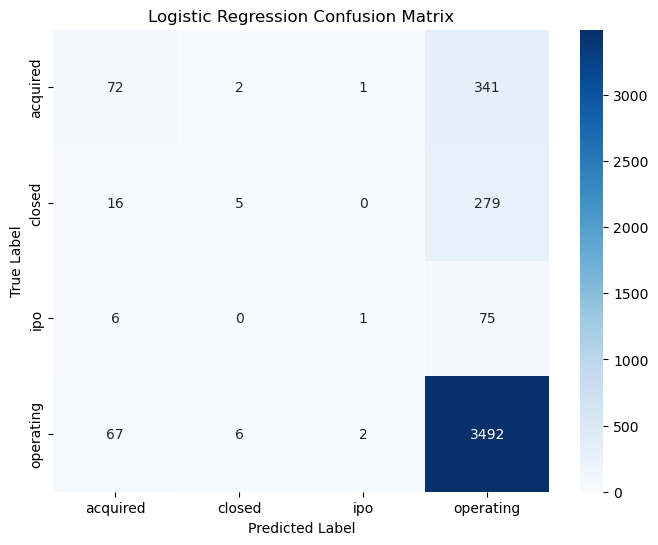


Random Forest Classification Report:
              precision    recall  f1-score   support

    acquired       0.46      0.19      0.27       416
      closed       0.26      0.05      0.08       300
         ipo       0.00      0.00      0.00        82
   operating       0.84      0.97      0.90      3567

    accuracy                           0.82      4365
   macro avg       0.39      0.30      0.31      4365
weighted avg       0.75      0.82      0.77      4365



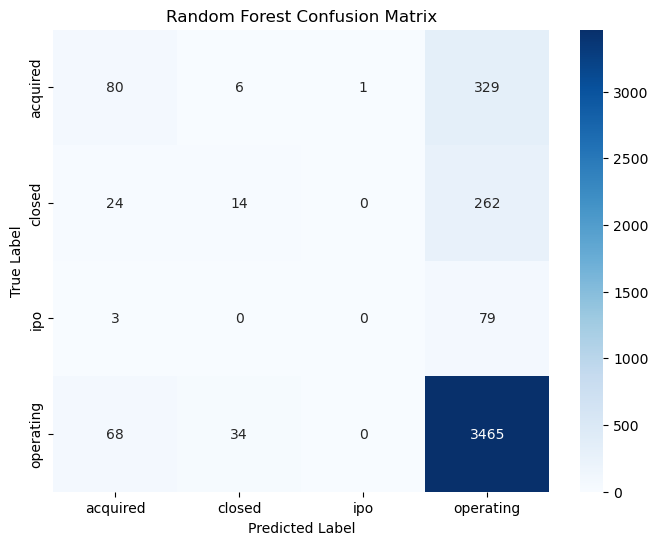


XGBoost Classification Report:
              precision    recall  f1-score   support

    acquired       0.44      0.22      0.29       416
      closed       0.38      0.04      0.08       300
         ipo       0.00      0.00      0.00        82
   operating       0.84      0.97      0.90      3567

    accuracy                           0.82      4365
   macro avg       0.42      0.31      0.32      4365
weighted avg       0.76      0.82      0.77      4365



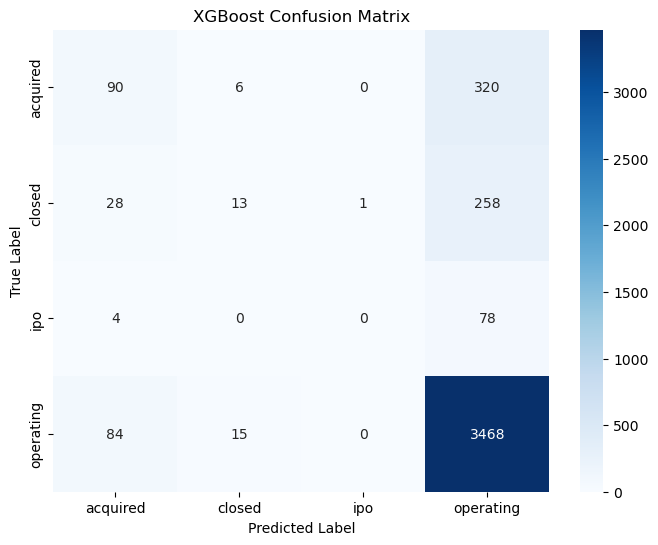


Plotting feature importance comparison...


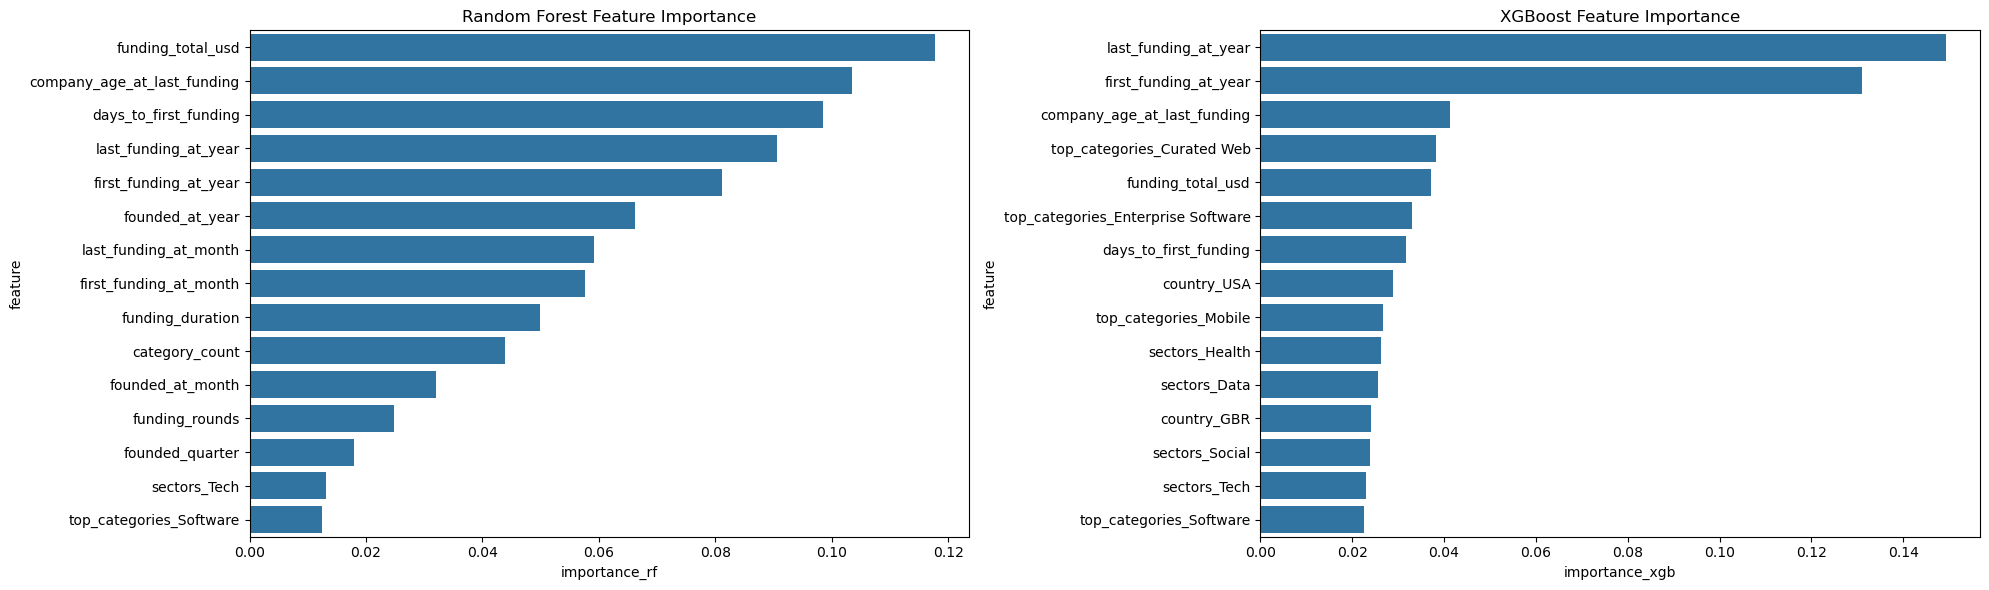


Top 10 Most Important Features (Random Forest vs XGBoost):
                        feature  importance_rf  importance_xgb
0             funding_total_usd       0.117672        0.037258
4   company_age_at_last_funding       0.103361        0.041325
2         days_to_first_funding       0.098416        0.031705
9          last_funding_at_year       0.090529        0.149257
7         first_funding_at_year       0.081069        0.130944
5               founded_at_year       0.066102        0.019793
10        last_funding_at_month       0.059145        0.022511
8        first_funding_at_month       0.057660        0.017902
3              funding_duration       0.049911        0.022384
14               category_count       0.043845        0.021133

Final evaluation on test set...

Logistic Regression Final Test Set Performance:
              precision    recall  f1-score   support

    acquired       0.45      0.20      0.28       418
      closed       0.50      0.01      0.02       319
  

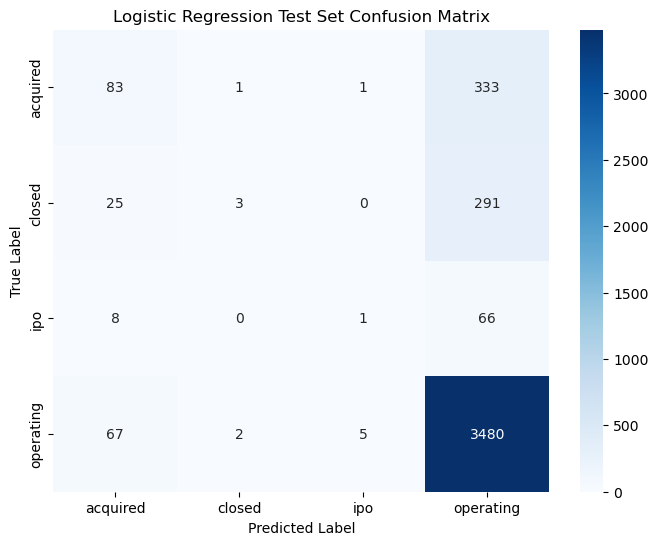


Random Forest Final Test Set Performance:
              precision    recall  f1-score   support

    acquired       0.44      0.20      0.28       418
      closed       0.39      0.04      0.08       319
         ipo       0.50      0.01      0.03        75
   operating       0.84      0.97      0.90      3554

    accuracy                           0.82      4366
   macro avg       0.54      0.31      0.32      4366
weighted avg       0.76      0.82      0.77      4366



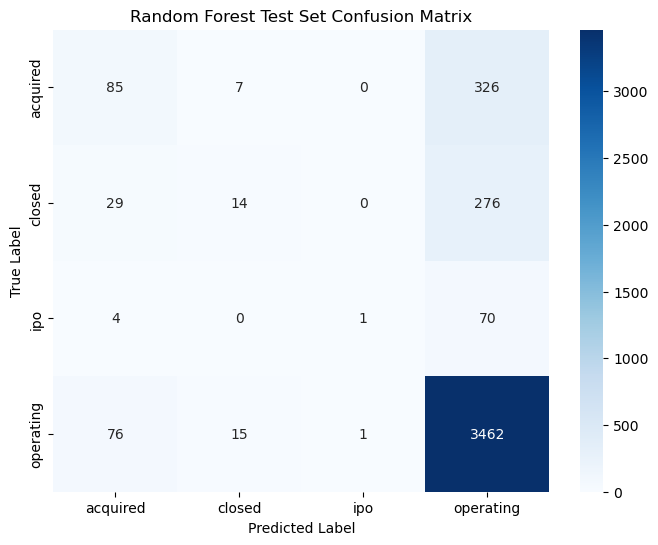


XGBoost Final Test Set Performance:
              precision    recall  f1-score   support

    acquired       0.44      0.23      0.30       418
      closed       0.48      0.03      0.06       319
         ipo       0.86      0.08      0.15        75
   operating       0.84      0.98      0.90      3554

    accuracy                           0.82      4366
   macro avg       0.66      0.33      0.35      4366
weighted avg       0.78      0.82      0.77      4366



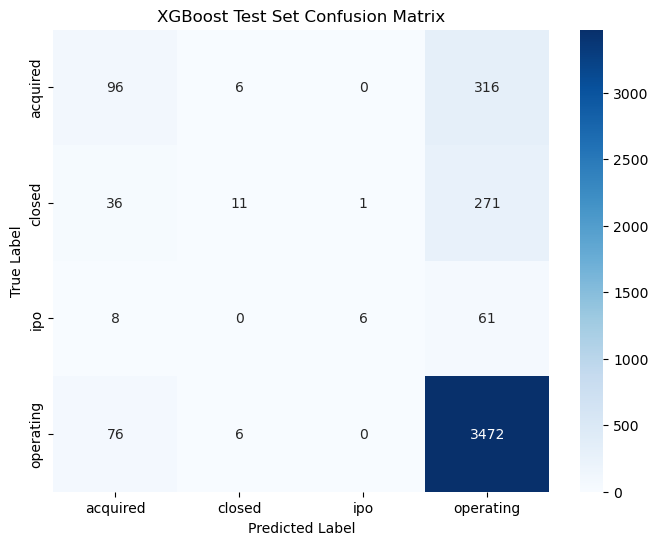


Model Performance Comparison:
                 Model  Cross-Val Score  Cross-Val Std  \
0  Logistic Regression         0.821077       0.005927   
1        Random Forest         0.822757       0.003846   
2              XGBoost         0.824360       0.003983   

   Validation F1 (weighted)  
0                  0.762450  
1                  0.766510  
2                  0.769892  


In [17]:

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df_final['status'])
print("Status categories:", dict(zip(le.classes_, le.transform(le.classes_))))

# Separate features and target
X = df_final.drop(['status', 'founded_at', 'last_funding_at'], axis=1)

# First split: separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate validation set from training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['funding_total_usd', 'funding_rounds', 'days_to_first_funding', 
                 'funding_duration', 'company_age_at_last_funding', 'founded_at_year',
                 'founded_at_month', 'first_funding_at_year', 'first_funding_at_month',
                 'last_funding_at_year', 'last_funding_at_month', 'founded_quarter',
                 'category_count', 'sector_count']

# Binary columns (no need to scale these)
binary_cols = [col for col in X.columns if col not in numerical_cols]

# Scale only numerical columns
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Define models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='mlogloss'  # for multi-class classification
)

def perform_cv(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"\n{model_name} Cross-Validation Scores:", cv_scores)
    print(f"{model_name} Average CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    return cv_scores

# Modify train_and_evaluate to store and return metrics
def train_and_evaluate(model, X_train, X_val, y_train, y_val, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Get classification report as dict
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
    
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=le.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return model, report

# Execute cross-validation for all models
print("\nPerforming cross-validation...")
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

cv_scores = {}
for name, model in models.items():
    cv_scores[name] = perform_cv(model, X_train_scaled, y_train, name)

# Train and evaluate all models
print("\nTraining and evaluating models...")
trained_models = {}
model_reports = {}
for name, model in models.items():
    trained_models[name], model_reports[name] = train_and_evaluate(
        model, X_train_scaled, X_val_scaled, y_train, y_val, name
    )

# Feature importance comparison
def plot_feature_importance_comparison():
    # Get feature importance for each model
    importances = {}
    
    # Random Forest importance
    rf_imp = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance_rf': trained_models['Random Forest'].feature_importances_
    })
    
    # XGBoost importance
    xgb_imp = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance_xgb': trained_models['XGBoost'].feature_importances_
    })
    
    # Merge importances
    all_imp = rf_imp.merge(xgb_imp, on='feature')
    
    # Plot top 15 features for both models
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Random Forest
    rf_sorted = all_imp.sort_values('importance_rf', ascending=False).head(15)
    sns.barplot(x='importance_rf', y='feature', data=rf_sorted, ax=ax1)
    ax1.set_title('Random Forest Feature Importance')
    
    # XGBoost
    xgb_sorted = all_imp.sort_values('importance_xgb', ascending=False).head(15)
    sns.barplot(x='importance_xgb', y='feature', data=xgb_sorted, ax=ax2)
    ax2.set_title('XGBoost Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return all_imp

# Plot feature importance comparison
print("\nPlotting feature importance comparison...")
feature_importance_comparison = plot_feature_importance_comparison()
print("\nTop 10 Most Important Features (Random Forest vs XGBoost):")
print(feature_importance_comparison.sort_values('importance_rf', ascending=False).head(10))

# Final evaluation on test set
def final_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Final Test Set Performance:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'{model_name} Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Final evaluation on test set
print("\nFinal evaluation on test set...")
for name, model in trained_models.items():
    final_evaluation(model, X_test_scaled, y_test, name)

def compare_models():
    # Create list to store results
    comparison_list = []
    
    for name in models.keys():
        comparison_list.append({
            'Model': name,
            'Cross-Val Score': cv_scores[name].mean(),
            'Cross-Val Std': cv_scores[name].std() * 2,
            'Validation F1 (weighted)': model_reports[name]['weighted avg']['f1-score']
        })
    
    # Convert list of dictionaries to DataFrame
    comparison = pd.DataFrame(comparison_list)
    return comparison

print("\nModel Performance Comparison:")
print(compare_models())

# Serialize best performing model for deployment in Streamlit Cloud

In [18]:
import pickle as pkl 
import joblib

# Save the trained XGBoost model
joblib.dump(trained_models['XGBoost'], 'xgboost_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the feature columns
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

['feature_columns.pkl']